
### Few remarks:
1. we have shown that the most efficient sparsity is a time window of consequtive voltage images of MEA recordings.
2. It is important to note the measurement is applied on MEA electrodes and remain constant for all of the measurement time. This is a limitation applied by aquisition.

In [ ]:
import matplotlib.pyplot as plt
size=15
parameters = {'axes.labelsize': size, 'axes.titlesize': size, 'figure.titlesize': size,
              'xtick.labelsize': size, 'ytick.labelsize': size, 'legend.fontsize': 15,
              'legend.title_fontsize': 15, 'figure.figsize':(16,4)}
plt.rcParams.update(parameters)
import seaborn as sns
import numpy as np
import tensorflow as tf
import seaborn as sn
import h5py
import time  
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV, Lars
from scipy.fftpack import dct, idct, fft, ifft
from scipy import linalg
from scipy import signal
import pywt
from skimage.metrics import structural_similarity as SSIM
import os
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
#given a liest of numpy array v 
def make_gif(v):
#    plt.rcParams['figure.figsize'] = [8,6]
    plt.rc('animation', html='html5')
    fig = plt.figure(figsize=(6,4))
    s = abs(v[0].reshape(100,100))
    im = plt.imshow(s, animated=True)

    def updatefig(i):
        im.set_array(abs(v[i].reshape(100,100)))
        return im,
    anim = animation.FuncAnimation(fig, updatefig,
                                   frames=len(v),interval=250,
                                   blit=True)
#    HTML(anim.to_html5_video())
    plt.close()
    return anim
#     writervideo = animation.FFMpegWriter(fps=4)
#     anim.save(str(name)+'.gif', writer=writervideo)
#     plt.close()

def make_sparse(x,t):
    l = x.reshape(-1)
    p = np.argsort(np.abs(l))[-t]
    s = np.ma.masked_where(np.abs(x) < np.abs(l[p]), x)
    y = np.ma.filled(s.astype(float), 0.0)
    return y

# gives the number of measurements and probability that guarantees RIP
def rip(k1, delta, l, k):  
    #k_star
    k_star = 2/(1-np.log(2))
    # k2
    k2 = delta**2 / (2*k_star) - 1 / (k1*np.log(42*np.e / delta))
    # number of measurements
    nm = int( round(k1*k*np.log(l/k) ) )
    # probability of RIP satisfaction
    p = 1 - 2*np.exp(k2*nm)
    return nm, p

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0): 
        return 100
    max_pixel = np.max(original)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

class OMP(OrthogonalMatchingPursuit):
    def __init__(self, k_sparse, M, A):
        super(OMP, self).__init__()
        self.M= M
        self.A= A
        self.omp= OrthogonalMatchingPursuit(n_nonzero_coefs=k_sparse, normalize=False)

    def __call__(self, v):
        self.y= np.dot(self.M, v)
        self.omp.fit(self.A, self.y)
        return self.omp.coef_
    
class OMPCV(OrthogonalMatchingPursuitCV):
    def __init__(self, M, A):
        super(OMPCV, self).__init__()
        self.M= M
        self.A= A
        self.ompcv= OrthogonalMatchingPursuit(normalize=False)

    def __call__(self, v):
        self.y= np.dot(self.M, v)
        self.ompcv.fit(self.A, self.y)
        return self.ompcv.coef_
    
class LARS(Lars):
    def __init__(self, k_sparse, M, A):
        super(LARS, self).__init__()
        self.M= M
        self.A= A
        self.lars= Lars(n_nonzero_coefs=k_sparse, normalize=False)

    def __call__(self, v):
        self.y= np.dot(self.M, v)
        self.lars.fit(self.A, self.y)
        return self.lars.coef_
    
def hard_thresh(x, k):
    p = x.shape[0]
    t = np.sort(np.abs(x))[::-1]    
    threshold = t[k-1]
    j = (np.abs(x) < threshold)
    x[j] = 0
    return x

def iht(y, A, v, k_sparse, iteration):
    x=np.zeros(len(v))
    for i in range(iteration):
        xn = x + A.T.dot(y - A.dot(x))
        x = hard_thresh(xn, k_sparse)
    return x

def soft_thresh(x, l1):
    return np.sign(x) * np.maximum(np.abs(x) - l1, 0.)

def ist(A, y, l1, maxit):
    x = np.zeros(A.shape[1])
    L = linalg.norm(A, ord=2) **2  # Lipschitz constant
    for _ in range(maxit):
        r= y - A.dot(x)
        z= x + A.T.dot(r)/L
        x= soft_thresh(z, l1 / L)
    return x

def fist(A, y, l1, maxit):
    x = np.zeros(A.shape[1])
    t = 1
    z = x.copy()
    L = linalg.norm(A, ord=2) **2
    for _ in range(maxit):
        xold = x.copy()
        r= y - A.dot(z)
        z = z + np.dot(A.T, r) / L
        x = soft_thresh(z, l1 / L)
        t0 = t
        t = (1. + np.sqrt(1. + 4. * t ** 2)) / 2.
        z = x + ((t0 - 1.) / t) * (x - xold)
    return x

def amp(A, y, l1, maxit):
    x= np.zeros(A.shape[1])
    z= y
    for _ in range(maxit):
        theta = l1 * np.sqrt(linalg.norm(z)**2/len(y)) # alpha*tau
        s= x + np.dot(A.T,z)
        x= soft_thresh(s, theta)
        # update with osenger
        b= linalg.norm(x,0)/len(y)
        z= y - np.dot(A,x) + b*z
    return x

### reade data and build dataset:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/Thesis/Codes/data'
dir = os.path.join(path,'100_RecordingFrames(f30tof130).npy')
with open(dir, 'rb') as f:
  rec= np.load(f)

nex=100
ney=100
l=nex*ney
t=30
v = rec[:t,:]

In [ ]:
make_gif(v.reshape((t,nex,ney)))

### With 1% of coefficients on F space we have a better sorting result

In [ ]:
vr=np.zeros(v.shape)
for i,x in enumerate(v):
    vr[i,:]= idct(make_sparse(dct(x,norm='ortho'), l//100),norm='ortho')

In [ ]:
ps=[]
for i in range(len(vr)):
  ps.append(PSNR(v[i],vr[i]))
psnr={'sparse':ps}

In [ ]:
ss=[]
for i in range(len(vr)):
  ss.append(SSIM(v[i],vr[i]))
ssim={'sparse':ss}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  This is separate from the ipykernel package so we can avoid doing imports until


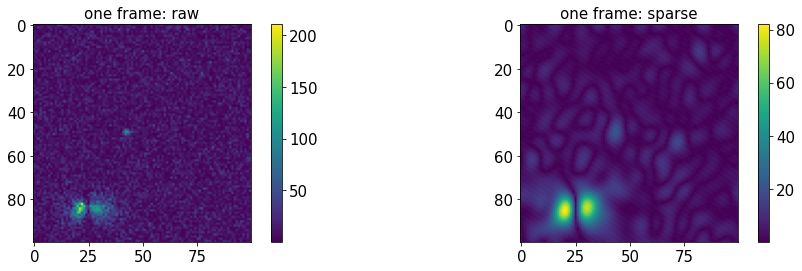

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(abs(v[5].reshape(nex,ney)))
plt.title('one frame: raw')
plt.colorbar()
plt.subplot(122)
plt.imshow(abs(vr[5].reshape(nex,ney)))
plt.title('one frame: sparse')
plt.colorbar()

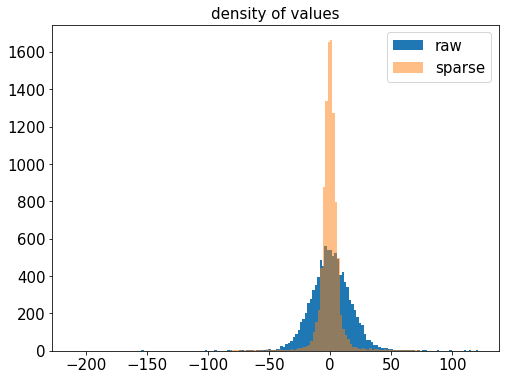

In [ ]:
plt.figure(figsize=(8,6))
HIST_BINS= np.arange(np.min(v[5]), np.max(v[5]), 2)
plt.hist(v[5], HIST_BINS, label='raw')
HIST_BINS= np.arange(np.min(vr[5]), np.max(vr[5]), 2)
plt.hist(vr[5], HIST_BINS, alpha = 0.5,label='sparse')
plt.title('density of values')
plt.legend()

In [ ]:
make_gif(vr.reshape((t,nex,ney)))

### check RIP, get number of measurements, build representation and measurement matrices

In [ ]:
k1=1
delta= .9
l= nex*ney
k= l//20
nm, p= rip(k1, delta, l, k)

print('number of measurements= %s (%s %%)'%(nm, 100*nm/l))
print('RIP probability= ', p)

number of measurements= 1498 (14.98 %)
RIP probability=  1.0


In [ ]:
df= idct(np.eye(nex*ney), norm='ortho')
Mg= np.random.normal(0.0, 1/np.sqrt(nm), (nm, l))
Mb= np.random.binomial(1, .15, size=(nm,l))
Mi= np.diag(np.random.binomial(1, .15, size=(l,)))
M=Mi
A= np.dot(M, df)
k_sparse= l//100
print('Sparsity= %s (%s %%)'%(k_sparse, 100*k_sparse/l))

Sparsity= 100 (1.0 %)


Text(0.5, 1.0, 'DCT matrix')

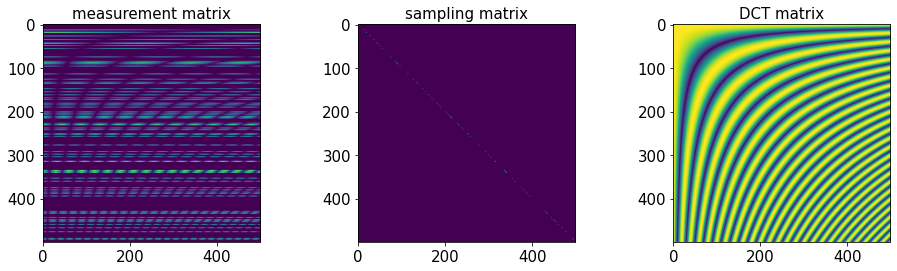

In [ ]:
plt.subplot(131)
plt.imshow(abs(A[:500,:500]))
plt.title('measurement matrix')
plt.subplot(132)
plt.imshow(abs(M[:500,:500]))
plt.title('sampling matrix')
plt.subplot(133)
plt.imshow(abs(df[:500,:500]))
plt.title('DCT matrix')

### Orthogonal Matching Pursuit (OMP):

In [ ]:
omp= OMP(k_sparse, M, A)
vr= np.zeros(v.shape)
for i,x in enumerate(v):
  print('\r', 'frame' + "." * 10, end=str(i)+'/'+str(t-1))
  z= omp(x)
  vr[i,:]=dct(z, norm='ortho')

 frame..........19/29

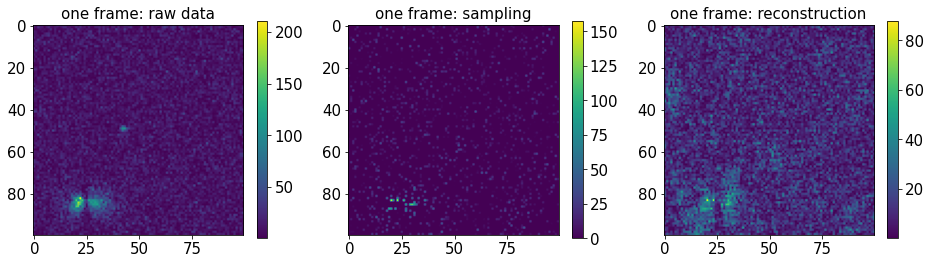

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(abs(v[5].reshape(nex,ney)))
plt.title('one frame: raw data')
plt.colorbar()
plt.subplot(132)
plt.imshow(abs(M.dot(v[5]).reshape(nex,ney)))
plt.title('one frame: sampling')
plt.colorbar()
plt.subplot(133)
plt.imshow(abs(vr[5].reshape(nex,ney)))
plt.title('one frame: reconstruction')
plt.colorbar()

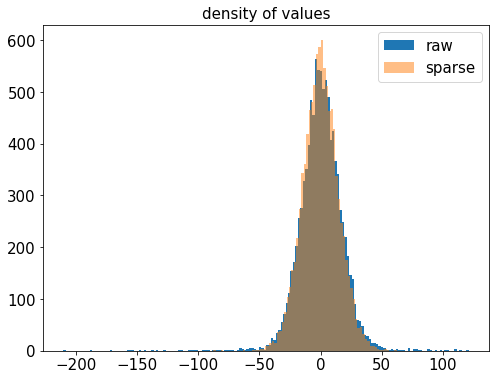

In [ ]:
plt.figure(figsize=(8,6))
HIST_BINS= np.arange(np.min(v[5]), np.max(v[5]), 2)
plt.hist(v[5], HIST_BINS, label='raw')
HIST_BINS= np.arange(np.min(vr[5]), np.max(vr[5]), 2)
plt.hist(vr[5], HIST_BINS, alpha = 0.5,label='sparse')
plt.title('density of values')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argum

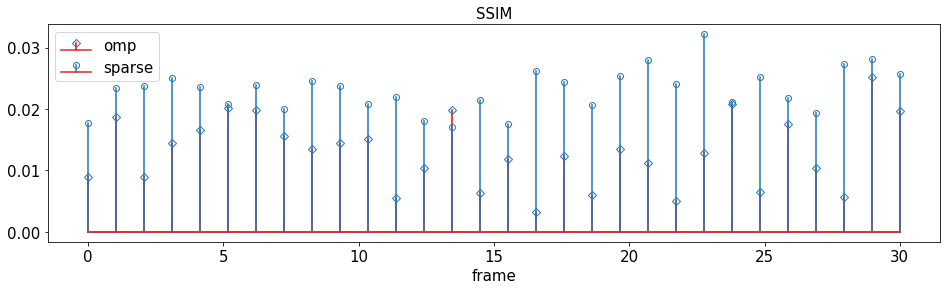

In [ ]:
ss=[]
for i in range(len(vr)):
  ss.append(SSIM(v[i],vr[i]))
ssim.update({'omp':ss})

x= x = np.linspace(0, len(v),len(v))
markerline, stemlines, baseline = plt.stem(x, ssim['omp'],
                                           linefmt='red',
                                           markerfmt='D',
                                           bottom=0,
                                           label='omp')
markerline.set_markerfacecolor('None')
markerline, stemlines, baseline = plt.stem(x, ssim['sparse'], label='sparse')
markerline.set_markerfacecolor('None')
plt.xlabel('frame')
plt.title('SSIM')
plt.legend()

In [ ]:
make_gif(vr)

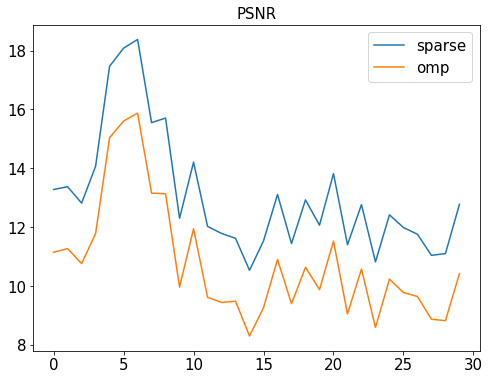

In [ ]:
ps=[]
for i in range(len(vr)):
  ps.append(PSNR(v[i],vr[i]))
psnr.update({'omp':ps})

plt.figure(figsize=(8,6))
plt.plot(psnr['sparse'], label= 'sparse')
plt.plot(psnr['omp'], label= 'omp')
plt.title('PSNR')
plt.legend()

### Orthogonal Maching Pursuit with Cross Validataion (OMPCV):

In [ ]:
ompcv = OMPCV(M, A)
vr=np.zeros(v.shape)
for i,x in enumerate(v):
  print('\r', 'frame' + "." * 10, end=str(i)+'/'+str(t-1))
  z= ompcv(x)
  vr[i,:]=dct(z, norm='ortho')

 frame..........29/29

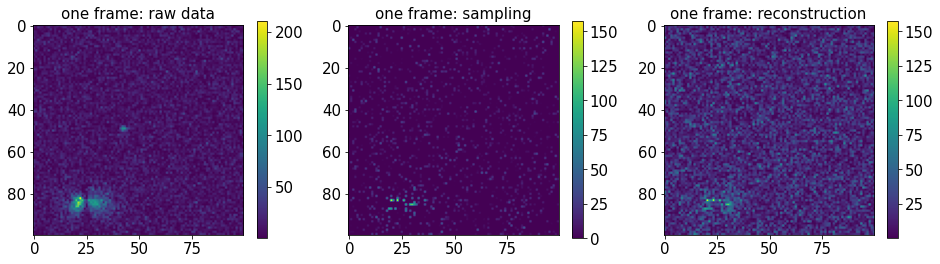

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(abs(v[5].reshape(nex,ney)))
plt.title('one frame: raw data')
plt.colorbar()
plt.subplot(132)
plt.imshow(abs(M.dot(v[5]).reshape(nex,ney)))
plt.title('one frame: sampling')
plt.colorbar()
plt.subplot(133)
plt.imshow(abs(vr[5].reshape(nex,ney)))
plt.title('one frame: reconstruction')
plt.colorbar()

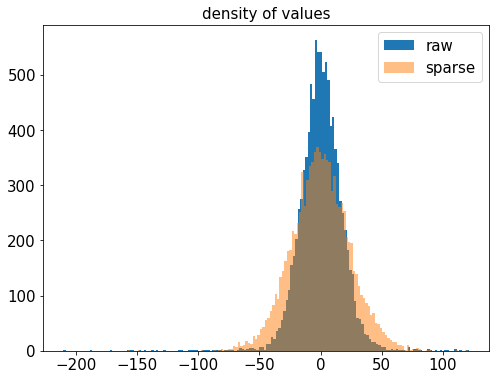

In [ ]:
plt.figure(figsize=(8,6))
HIST_BINS= np.arange(np.min(v[5]), np.max(v[5]), 2)
plt.hist(v[5], HIST_BINS, label='raw')
HIST_BINS= np.arange(np.min(vr[5]), np.max(vr[5]), 2)
plt.hist(vr[5], HIST_BINS, alpha = 0.5,label='sparse')
plt.title('density of values')
plt.legend()

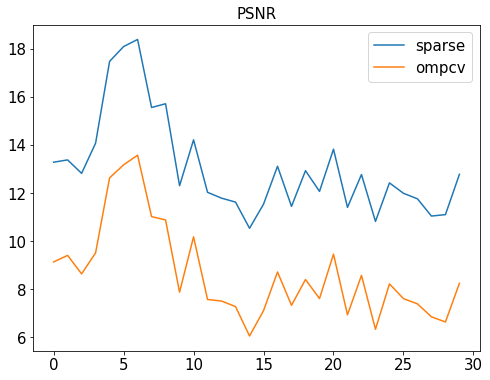

In [ ]:
ps=[]
for i in range(len(vr)):
  ps.append(PSNR(v[i],vr[i]))
psnr.update({'ompcv':ps})

plt.figure(figsize=(8,6))
plt.plot(psnr['sparse'], label= 'sparse')
plt.plot(psnr['ompcv'], label= 'ompcv')
plt.title('PSNR')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argum

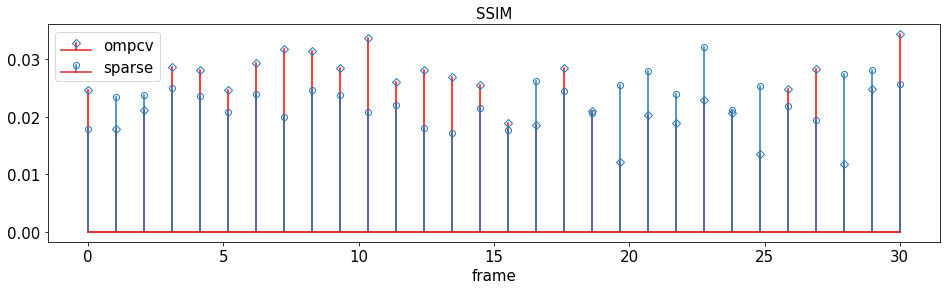

In [ ]:
ss=[]
for i in range(len(vr)):
  ss.append(SSIM(v[i],vr[i]))
ssim.update({'ompcv':ss})

x= x = np.linspace(0, len(v),len(v))
markerline, stemlines, baseline = plt.stem(x, ssim['ompcv'],
                                           linefmt='red',
                                           markerfmt='D',
                                           bottom=0,
                                           label='ompcv')
markerline.set_markerfacecolor('None')
markerline, stemlines, baseline = plt.stem(x, ssim['sparse'], label='sparse')
markerline.set_markerfacecolor('None')
plt.xlabel('frame')
plt.title('SSIM')
plt.legend()

In [ ]:
make_gif(vr)

### Least Angle Regression

In [ ]:
lars = LARS(k_sparse, M, A)
vr=np.zeros(v.shape)
for i,x in enumerate(v):
  print('\r', 'frame' + "." * 10, end=str(i)+'/'+str(t-1))
  z= lars(x)
  vr[i,:]=dct(z, norm='ortho')

 frame..........29/29

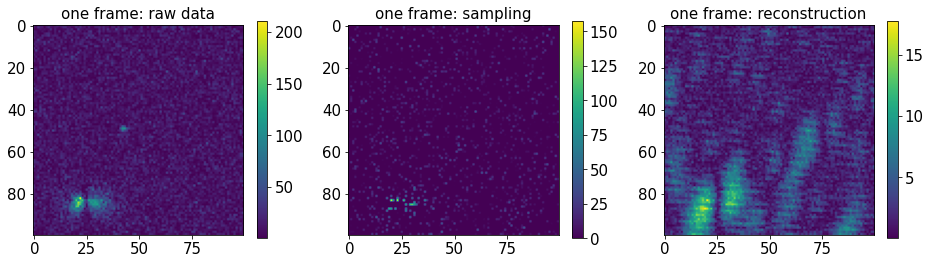

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(abs(v[5].reshape(nex,ney)))
plt.title('one frame: raw data')
plt.colorbar()
plt.subplot(132)
plt.imshow(abs(M.dot(v[5]).reshape(nex,ney)))
plt.title('one frame: sampling')
plt.colorbar()
plt.subplot(133)
plt.imshow(abs(vr[5].reshape(nex,ney)))
plt.title('one frame: reconstruction')
plt.colorbar()

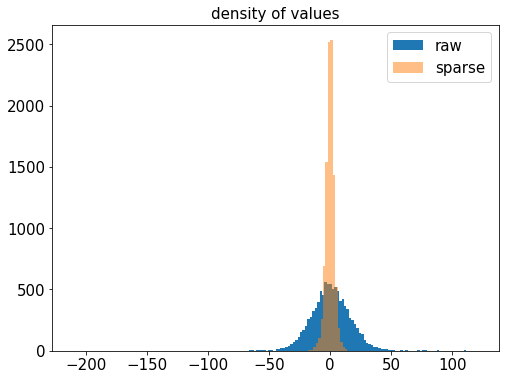

In [ ]:
plt.figure(figsize=(8,6))
HIST_BINS= np.arange(np.min(v[5]), np.max(v[5]), 2)
plt.hist(v[5], HIST_BINS, label='raw')
HIST_BINS= np.arange(np.min(vr[5]), np.max(vr[5]), 2)
plt.hist(vr[5], HIST_BINS, alpha = 0.5,label='sparse')
plt.title('density of values')
plt.legend()

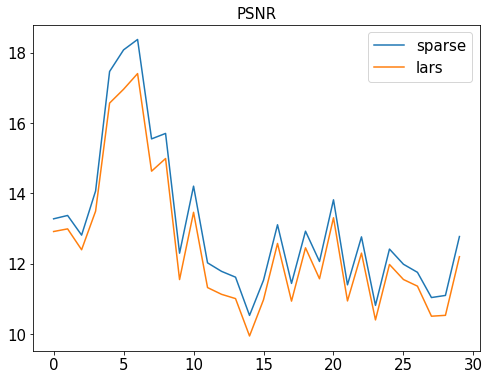

In [ ]:
ps=[]
for i in range(len(vr)):
  ps.append(PSNR(v[i],vr[i]))
psnr.update({'lars':ps})

plt.figure(figsize=(8,6))
plt.plot(psnr['sparse'], label= 'sparse')
plt.plot(psnr['lars'], label= 'lars')
plt.title('PSNR')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argum

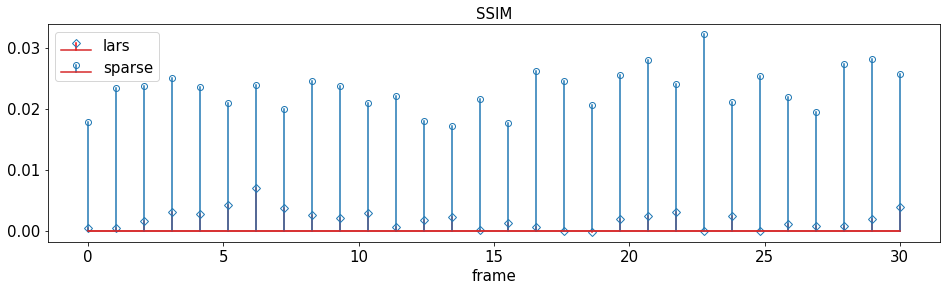

In [ ]:
ss=[]
for i in range(len(vr)):
  ss.append(SSIM(v[i],vr[i]))
ssim.update({'lars':ss})

x= x = np.linspace(0, len(v),len(v))
markerline, stemlines, baseline = plt.stem(x, ssim['lars'],
                                           linefmt='red',
                                           markerfmt='D',
                                           bottom=0,
                                           label='lars')
markerline.set_markerfacecolor('None')
markerline, stemlines, baseline = plt.stem(x, ssim['sparse'], label='sparse')
markerline.set_markerfacecolor('None')
plt.xlabel('frame')
plt.title('SSIM')
plt.legend()

In [ ]:
make_gif(vr)

### Itereative Hard Thresholding

In [ ]:
ks = nex*ney//100
print('Sparsity= %s (%s %%)'%(ks, 100*ks/l))

it=1000
vr=np.zeros(v.shape)
for i,x in enumerate(v):
  print('\r', 'frame' + "." * 10, end=str(i)+'/'+str(t-1))
  y= np.dot(M, x)
  z= iht(y,A,x,ks, it)
  vr[i,:]=dct(z, norm='ortho')

Sparsity= 100 (1.0 %)
 frame..........29/29

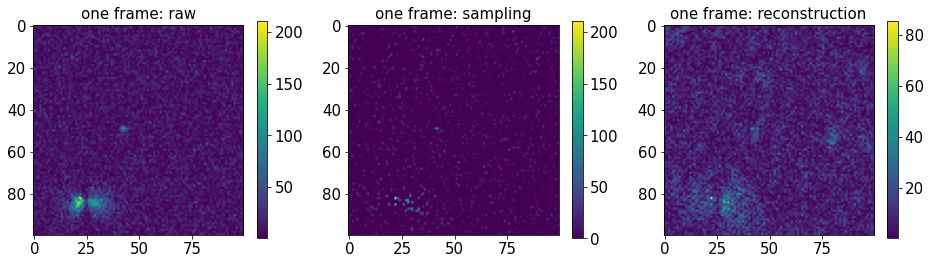

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(abs(v[5].reshape(nex,ney)))
plt.title('one frame: raw')
plt.colorbar()
plt.subplot(132)
plt.imshow(abs(M.dot(v[5]).reshape(nex,ney)))
plt.title('one frame: sampling')
plt.colorbar()
plt.subplot(133)
plt.imshow(abs(vr[5].reshape(nex,ney)))
plt.title('one frame: reconstruction')
plt.colorbar()

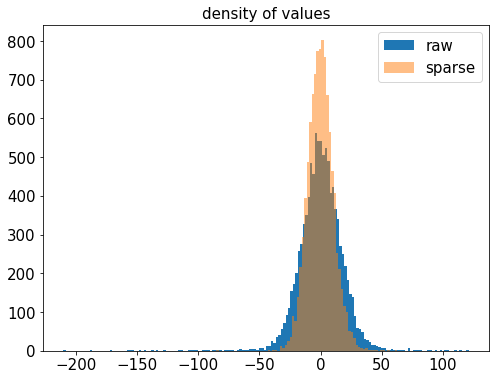

In [ ]:
plt.figure(figsize=(8,6))
HIST_BINS= np.arange(np.min(v[5]), np.max(v[5]), 2)
plt.hist(v[5], HIST_BINS, label='raw')
HIST_BINS= np.arange(np.min(vr[5]), np.max(vr[5]), 2)
plt.hist(vr[5], HIST_BINS, alpha = 0.5,label='sparse')
plt.title('density of values')
plt.legend()

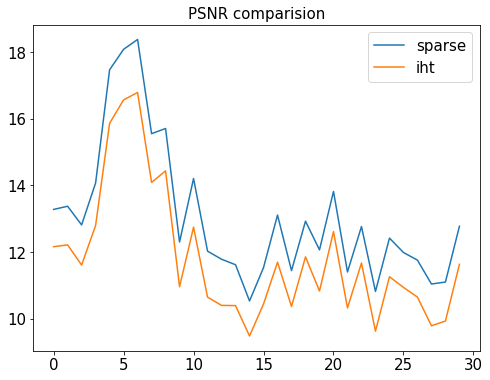

In [ ]:
ps=[]
for i in range(len(vr)):
  ps.append(PSNR(v[i],vr[i]))
psnr.update({'iht':ps})

plt.figure(figsize=(8,6))
plt.plot(psnr['sparse'], label= 'sparse')
plt.plot(psnr['iht'], label= 'iht')
plt.title('PSNR comparision')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argum

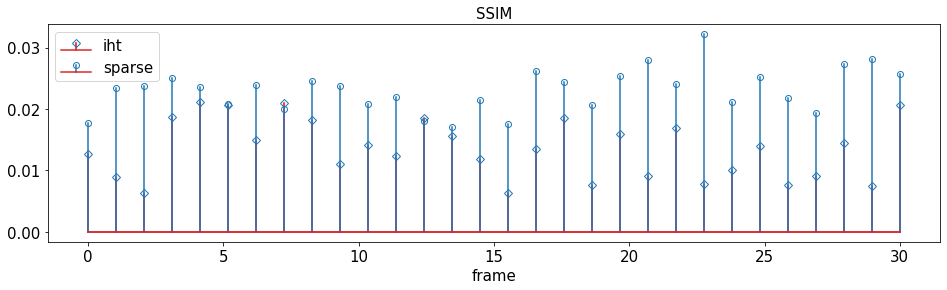

In [ ]:
ss=[]
for i in range(len(vr)):
  ss.append(SSIM(v[i],vr[i]))
ssim.update({'iht':ss})

x= x = np.linspace(0, len(v),len(v))
markerline, stemlines, baseline = plt.stem(x, ssim['iht'],
                                           linefmt='red',
                                           markerfmt='D',
                                           bottom=0,
                                           label='iht')
markerline.set_markerfacecolor('None')
markerline, stemlines, baseline = plt.stem(x, ssim['sparse'], label='sparse')
markerline.set_markerfacecolor('None')
plt.xlabel('frame')
plt.title('SSIM')
plt.legend()

In [ ]:
make_gif(vr)

### Iterative Soft Thresholding

In [ ]:
l1 = 3  # regularization parameter
maxit = 1000
vr=np.zeros(v.shape)
for i,x in enumerate(v):
  print('\r', 'frame' + "." * 10, end=str(i)+'/'+str(t-1))
#  time.sleep(.5)
  y= np.dot(M, x)
  z= ist(A, y, l1, maxit)
  vr[i,:]=dct(z, norm='ortho')

 frame..........29/29

In [ ]:
dir = os.path.join(path,'vr_ista(l=3).npy')
with open(dir, 'wb') as f:
    np.save(f, vr)

In [ ]:
dir = os.path.join(path,'vr_ista(l=3).npy')
with open(dir, 'rb') as f:
  vr = np.load(f)

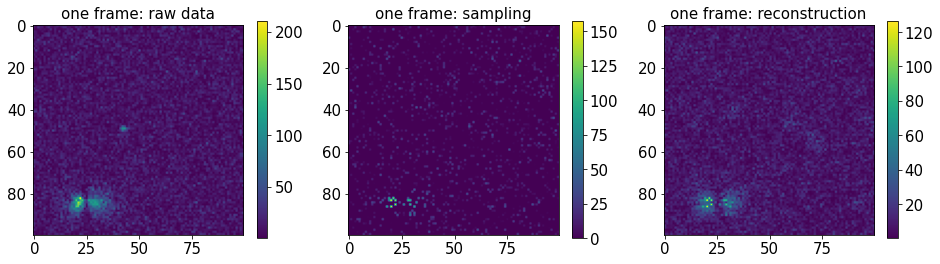

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(abs(v[5].reshape(nex,ney)))
plt.title('one frame: raw data')
plt.colorbar()
plt.subplot(132)
plt.imshow(abs(M.dot(v[5]).reshape(nex,ney)))
plt.title('one frame: sampling')
plt.colorbar()
plt.subplot(133)
plt.imshow(abs(vr[5].reshape(nex,ney)))
plt.title('one frame: reconstruction')
plt.colorbar()

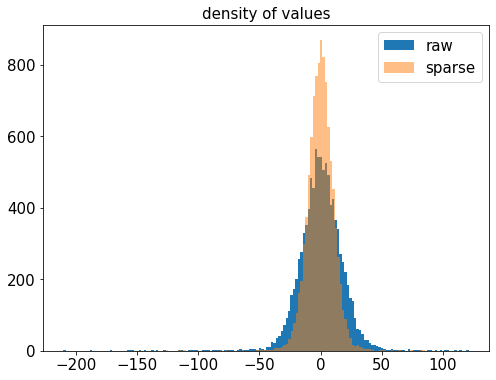

In [ ]:
plt.figure(figsize=(8,6))
HIST_BINS= np.arange(np.min(v[5]), np.max(v[5]), 2)
plt.hist(v[5], HIST_BINS, label='raw')
HIST_BINS= np.arange(np.min(vr[5]), np.max(vr[5]), 2)
plt.hist(vr[5], HIST_BINS, alpha = 0.5,label='sparse')
plt.title('density of values')
plt.legend()

<Figure size 576x432 with 0 Axes>

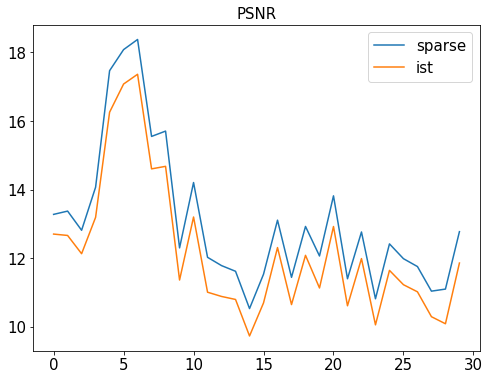

In [ ]:
ps=[]
for i in range(len(vr)):
  ps.append(PSNR(v[i],vr[i]))
psnr.update({'ist':ps})

plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))
plt.plot(psnr['sparse'], label= 'sparse')
plt.plot(psnr['ist'], label= 'ist')
plt.title('PSNR')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argum

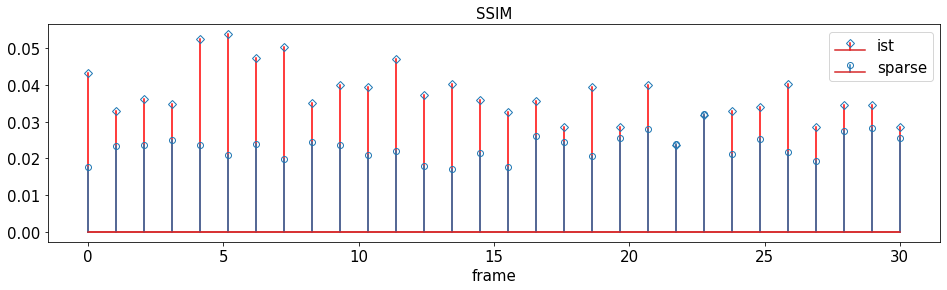

In [ ]:
ss=[]
for i in range(len(vr)):
  ss.append(SSIM(v[i],vr[i]))
ssim.update({'ist':ss})

x= x = np.linspace(0, len(v),len(v))
markerline, stemlines, baseline = plt.stem(x, ssim['ist'],
                                           linefmt='red',
                                           markerfmt='D',
                                           bottom=0,
                                           label='ist')
markerline.set_markerfacecolor('None')
markerline, stemlines, baseline = plt.stem(x, ssim['sparse'], label='sparse')
markerline.set_markerfacecolor('None')
plt.xlabel('frame')
plt.title('SSIM')
plt.legend()

In [ ]:
make_gif(vr)

### Fast IST

In [ ]:
l1 = 4  # regularization parameter
maxit = 1000
vr=np.zeros(v.shape)
for i,x in enumerate(v):
  print('\r', 'frame' + "." * 10, end=str(i)+'/'+str(len(v)-1))
  y= np.dot(M, x)
  z= fist(A, y, l1, maxit)
  vr[i,:]=dct(z, norm='ortho')

 frame..........29

In [ ]:
# dir = os.path.join(path,'vr_fista(l=4).npy')
# with open(dir, 'wb') as f:
#     np.save(f, vr)

In [ ]:
dir = os.path.join(path,'vr_fista(l=4).npy')
with open(dir, 'rb') as f:
  vr = np.load(f)

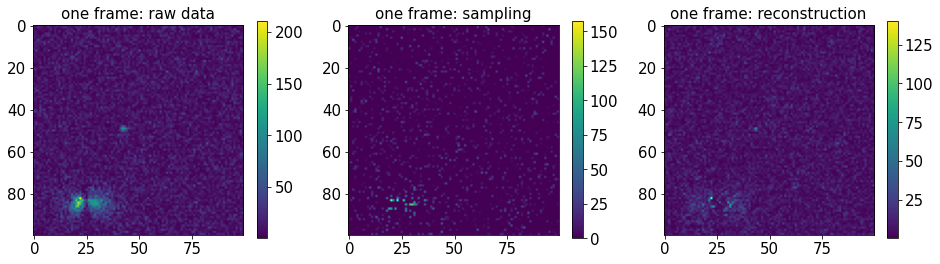

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(abs(v[5].reshape(nex,ney)))
plt.title('one frame: raw data')
plt.colorbar()
plt.subplot(132)
plt.imshow(abs(M.dot(v[5]).reshape(nex,ney)))
plt.title('one frame: sampling')
plt.colorbar()
plt.subplot(133)
plt.imshow(abs(vr[5].reshape(nex,ney)))
plt.title('one frame: reconstruction')
plt.colorbar()

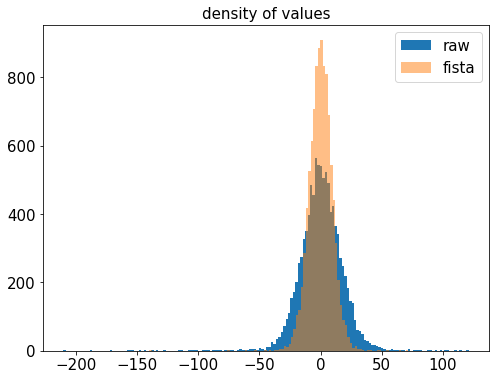

In [ ]:
plt.figure(figsize=(8,6))
HIST_BINS= np.arange(np.min(v[5]), np.max(v[5]), 2)
plt.hist(v[5], HIST_BINS, label='raw')
HIST_BINS= np.arange(np.min(vr[5]), np.max(vr[5]), 2)
plt.hist(vr[5], HIST_BINS, alpha = 0.5,label='fista')
plt.title('density of values')
plt.legend()

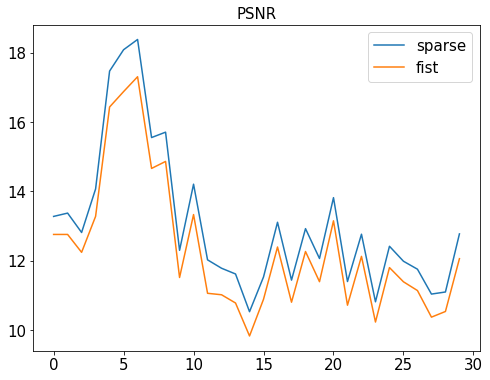

In [ ]:
ps=[]
for i in range(len(vr)):
  ps.append(PSNR(v[i],vr[i]))
psnr.update({'fist':ps})

plt.figure(figsize=(8,6))
plt.plot(psnr['sparse'], label= 'sparse')
plt.plot(psnr['fist'], label= 'fist')
plt.title('PSNR')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argum

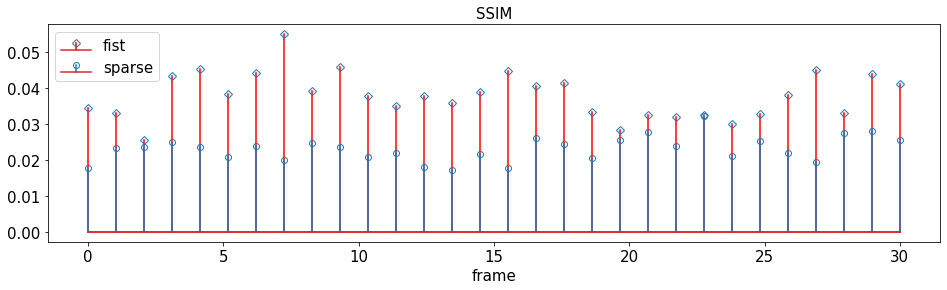

In [ ]:
ss=[]
for i in range(len(vr)):
  ss.append(SSIM(v[i],vr[i]))
ssim.update({'fist':ss})

x= x = np.linspace(0, len(v),len(v))
markerline, stemlines, baseline = plt.stem(x, ssim['fist'],
                                           linefmt='red',
                                           markerfmt='D',
                                           bottom=0,
                                           label='fist')
markerline.set_markerfacecolor('None')
markerline, stemlines, baseline = plt.stem(x, ssim['sparse'], label='sparse')
markerline.set_markerfacecolor('None')
plt.xlabel('frame')
plt.title('SSIM')
plt.legend()

In [ ]:
make_gif(vr)

### Approximate Message Passing

In [ ]:
l1 = 1  # regularization parameter
maxit = 100
vr=np.zeros(v.shape)
for i,x in enumerate(v):
  print('\r', 'frame' + "." * 10, end=str(i)+'/'+str(len(v)-1))
  y= np.dot(M, x)
  z= amp(A, y, l1, maxit)
  vr[i,:]=dct(z, norm='ortho')

 frame..........29/29

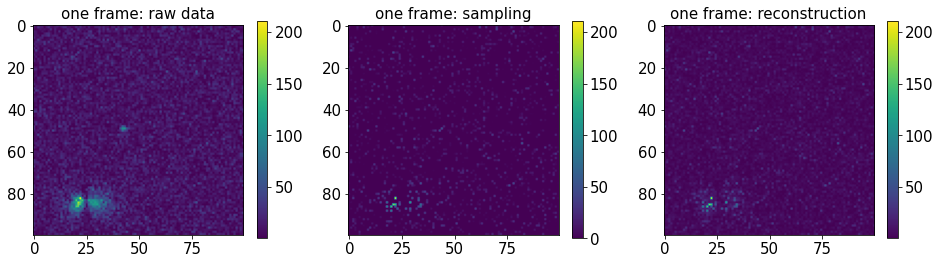

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(abs(v[5].reshape(nex,ney)))
plt.title('one frame: raw data')
plt.colorbar()
plt.subplot(132)
plt.imshow(abs(M.dot(v[5]).reshape(nex,ney)))
plt.title('one frame: sampling')
plt.colorbar()
plt.subplot(133)
plt.imshow(abs(vr[5].reshape(nex,ney)))
plt.title('one frame: reconstruction')
plt.colorbar()

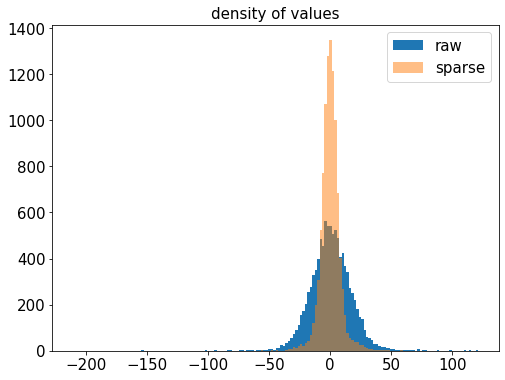

In [ ]:
plt.figure(figsize=(8,6))
HIST_BINS= np.arange(np.min(v[5]), np.max(v[5]), 2)
plt.hist(v[5], HIST_BINS, label='raw')
HIST_BINS= np.arange(np.min(vr[5]), np.max(vr[5]), 2)
plt.hist(vr[5], HIST_BINS, alpha = 0.5,label='sparse')
plt.title('density of values')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argum

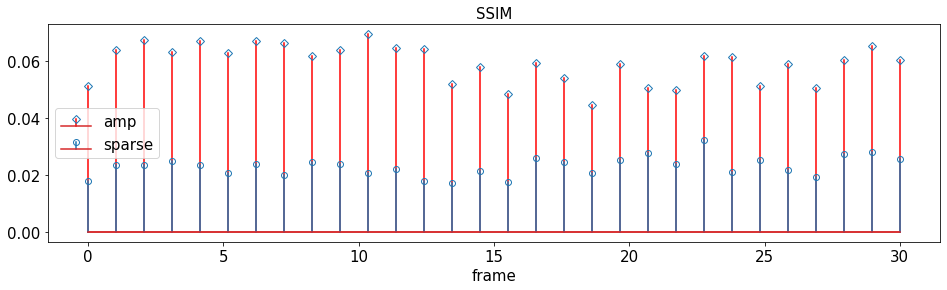

In [ ]:
ss=[]
for i in range(len(vr)):
  ss.append(SSIM(v[i],vr[i]))
ssim.update({'amp':ss})

x= x = np.linspace(0, len(v),len(v))
markerline, stemlines, baseline = plt.stem(x, ssim['amp'],
                                           linefmt='red',
                                           markerfmt='D',
                                           bottom=0,
                                           label='amp')
markerline.set_markerfacecolor('None')
markerline, stemlines, baseline = plt.stem(x, ssim['sparse'], label='sparse')
markerline.set_markerfacecolor('None')
plt.xlabel('frame')
plt.title('SSIM')
plt.legend()

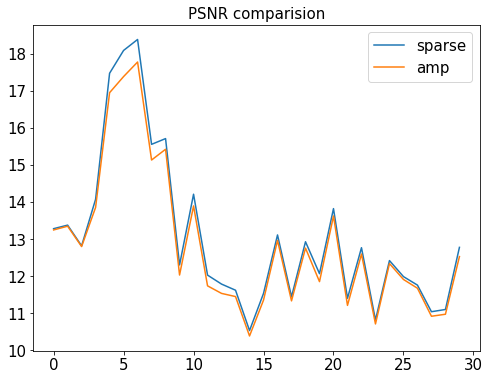

In [ ]:
ps=[]
for i in range(len(vr)):
  ps.append(PSNR(v[i],vr[i]))
psnr.update({'amp':ps})

plt.figure(figsize=(8,6))
plt.plot(psnr['sparse'], label= 'sparse')
plt.plot(psnr['amp'], label= 'amp')
plt.title('PSNR comparision')
plt.legend()

In [ ]:
make_gif(vr)